In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
import importlib as il
import datetime as dt
from scipy.interpolate import CubicSpline

from utility_programs import filters
from scipy.signal import find_peaks, savgol_filter
from multiprocessing import Pool, cpu_count


In [2]:
path = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Cesar_data/'


date = ['20130316', '20130317', '20130318']
data = []

for d in date:
    p = path + 'file' + d + '.dTEC'
    df = df = pd.read_csv(p, delim_whitespace=True, skiprows=1)
    lat1 = []
    lat2 = []
    lon1 = []
    lon2 = []
    dtec = []
    ds = xr.Dataset.from_dataframe(df)
    print(ds)
    data.append(ds)

<xarray.Dataset>
Dimensions:  (index: 86131)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 86125 86126 86127 86128 86129 86130
Data variables:
    lat1     (index) float64 -80.0 -80.0 -80.0 -80.0 ... 62.0 62.0 62.0 62.0
    lat2     (index) float64 -79.5 -79.5 -79.5 -79.5 ... 62.5 62.5 62.5 62.5
    lon1     (index) int64 0 180 360 540 720 ... 75420 75600 75780 75960 76140
    lon2     (index) int64 360 540 720 900 1080 ... 75960 76140 76320 76500
    dtec     (index) int64 23 28 80 28 25 25 11 7 4 ... 79 80 30 80 81 82 81 81
<xarray.Dataset>
Dimensions:  (index: 103063)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 ... 103058 103059 103060 103061 103062
Data variables:
    lat1     (index) float64 -80.0 -80.0 -80.0 -80.0 ... 62.0 62.0 62.0 62.0
    lat2     (index) float64 -79.5 -79.5 -79.5 -79.5 ... 62.5 62.5 62.5 62.5
    lon1     (index) int64 0 180 360 540 720 ... 75240 75420 75600 75780 75960
    lon2     (index) int64 360 540 720 900 1080 ... 75780 75960 76140 

In [3]:
dates = ['2011-08-06']

for d in dates:
    p = path + d + '.csv'
    df = pd.read_csv(p)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace = True)
    ds = df.to_xarray()
    print(ds)


<xarray.Dataset>
Dimensions:   (Datetime: 252357)
Coordinates:
  * Datetime  (Datetime) datetime64[ns] 2011-08-05 ... 2011-08-07T23:57:00
Data variables:
    Glat      (Datetime) float64 -44.0 23.5 -29.0 -2.0 ... -25.5 -54.0 -5.5 17.5
    dTEC      (Datetime) float64 -0.3556 -0.3778 -0.4222 ... -0.3778 -0.3333


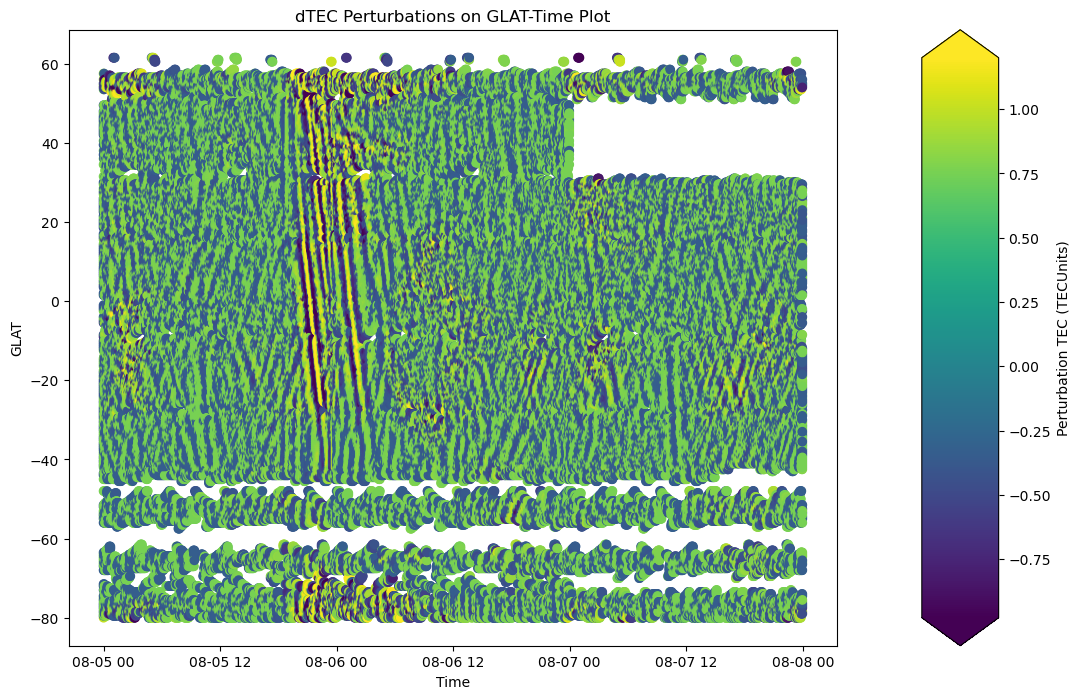

In [4]:
fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
c = ax[0].scatter(ds.Datetime.values, ds.Glat.values, c=ds.dTEC.values)
ax[0].set_title('dTEC Perturbations on GLAT-Time Plot')
ax[0].set_ylabel('GLAT')
ax[0].set_xlabel('Time')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
fig.show()

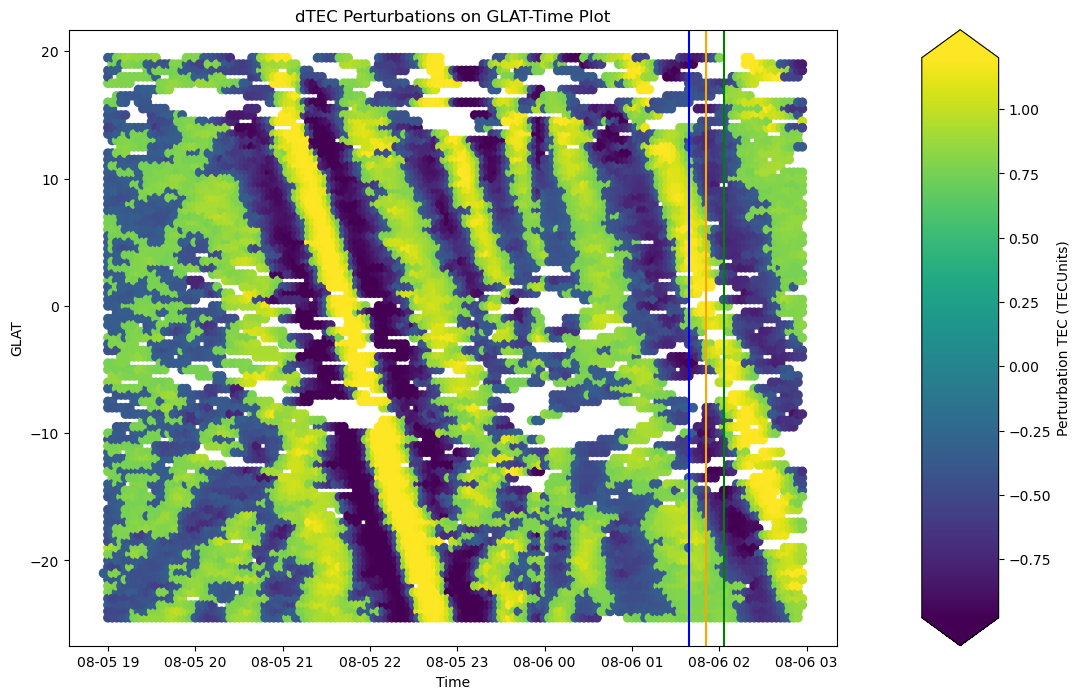

In [12]:
a = 70000
b = 100000

ds_n = ds.isel(Datetime=slice(a,b))

# Limits of latitudes
l1 = -25
l2 = 20
ds_n = ds_n.where((ds_n.Glat > l1), drop=True)
ds_n = ds_n.where((ds_n.Glat < l2), drop=True)

# index to set the time of observations
time1 = 10000
time2 = 10250
time3 = 10500

#mask = [(i > -40 and i < 50) for i in ds_n.Glat.values]

fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
ax[0].axvline(x=ds_n.Datetime.values[time1], color='blue')
ax[0].axvline(x=ds_n.Datetime.values[time2], color='orange')
ax[0].axvline(x=ds_n.Datetime.values[time3], color='green')
c = ax[0].scatter(ds_n.Datetime.values, ds_n.Glat.values, c=ds_n.dTEC.values)
ax[0].set_title('dTEC Perturbations on GLAT-Time Plot')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('GLAT')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
fig.show()

In [56]:
def smoothen(func, lats):
    y = savgol_filter(func.dTEC.values, 5, 1)
    cs = CubicSpline(func.Glat.values, y)
    y1 = cs(lats)
    df = pd.DataFrame()
    df['Glat'] = lats
    df['dTEC'] = y1

    return df

11816 161
2011-08-06T01:39:00.000000000 2011-08-06T01:51:00.000000000 2011-08-06T02:03:00.000000000


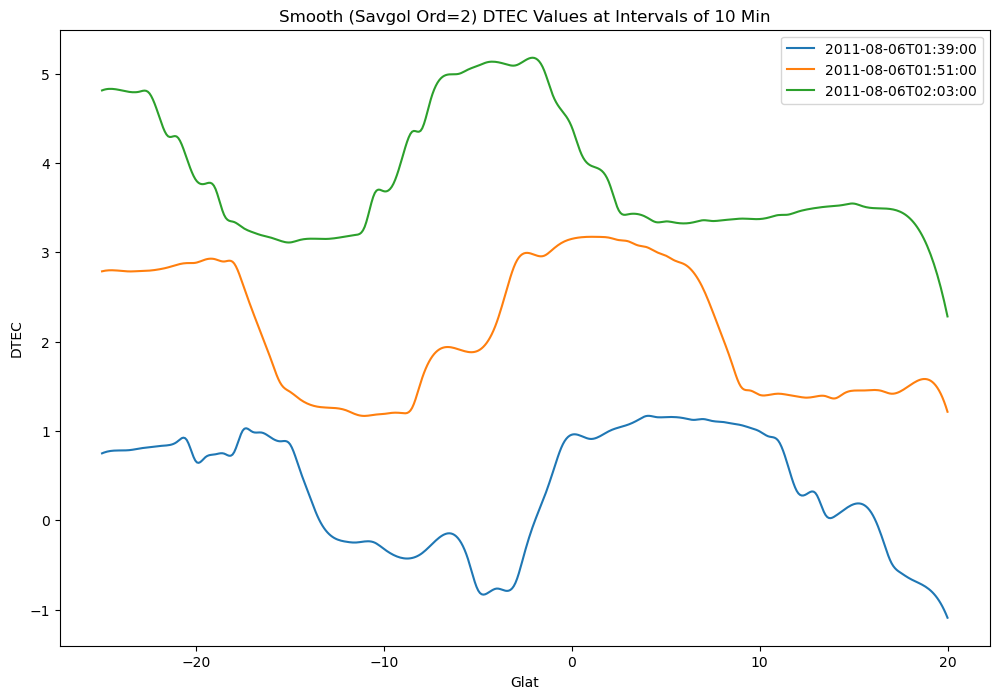

In [64]:
print(len(ds_n.Glat.values), len(np.unique(ds_n.Datetime.values)))

d = ds_n.Datetime.values[time1]
e = ds_n.Datetime.values[time2]
f = ds_n.Datetime.values[time3]
print(d,e,f)

df = ds_n.to_pandas()
df_1 = (df.iloc[np.where((ds_n.Datetime == d))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
df_2 = (df.iloc[np.where((ds_n.Datetime == e))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
df_3 = (df.iloc[np.where((ds_n.Datetime == f))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)

#print(len(df1.dTEC.values), len(df2.dTEC.values), len(df3.dTEC.values)) 
lats = np.linspace(l1,l2, 500)
df1 = smoothen(df_1, lats)
df2 = smoothen(df_2, lats)
df3 = smoothen(df_3, lats)

plt.figure(figsize=(12,8))
plt.plot(df1.Glat.values, df1.dTEC.values, label = str(d)[:-10])
plt.plot(df2.Glat.values, df2.dTEC.values+2, label = str(e)[:-10])
plt.plot(df3.Glat.values, df3.dTEC.values+4, label = str(f)[:-10])
plt.title('Smooth (Savgol Ord=2) DTEC Values at Intervals of 10 Min')
plt.xlabel('Glat')
plt.ylabel('DTEC')
plt.legend()

In [58]:
def correlation(df1, df2):
    corr1 = []
    for i in range(len(df2)-10):
        l1 = len(df2)-10
        n = 0
        d1 = 0
        d2 = 0
        u1 = np.sum(df1[i:l1])/(l1-i)
        u2 = np.sum(df2[:l1-i])/(l1-i)
        
        for j,k in zip(df1[i:l1], df2[:l1-i]):
            n += (j-u1)*(k-u2)
            d1 += (j-u1)**2
            d2 += (k-u2)**2
        c = n/(np.sqrt(d1*d2))
        corr1.append(c)
    
    return corr1

/tmp/ipykernel_22873/3761207125.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c = n/(np.sqrt(d1*d2))


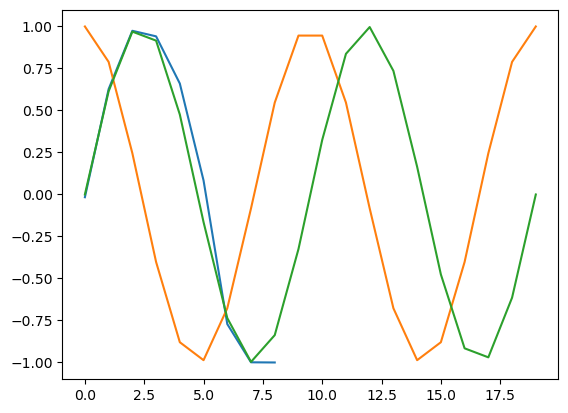

In [12]:
'''
import math

# Example to show the working of shifted cross-correlation function

in_array = np.linspace(-(2 * np.pi), 2 * np.pi, 20) 
  
cos = [] 
sin = []
for i in range(len(in_array)): 
    cos.append(math.cos(in_array[i])) 
    sin.append(math.sin(in_array[i]))
    i += 1
c = correlation(sin, cos)
plt.plot(c)
plt.plot(cos)
plt.plot(sin)
''';

/tmp/ipykernel_162197/3761207125.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c = n/(np.sqrt(d1*d2))


Lat diff of peaks 1.082164328657317
Shift 1 = 3.697394789579157 glats, Shift 2 = 4.779559118236474 glats
slope 1 = 0.30811623246492975 (glat/min), Slope 2 = 0.39829659318637284 (glat/min)


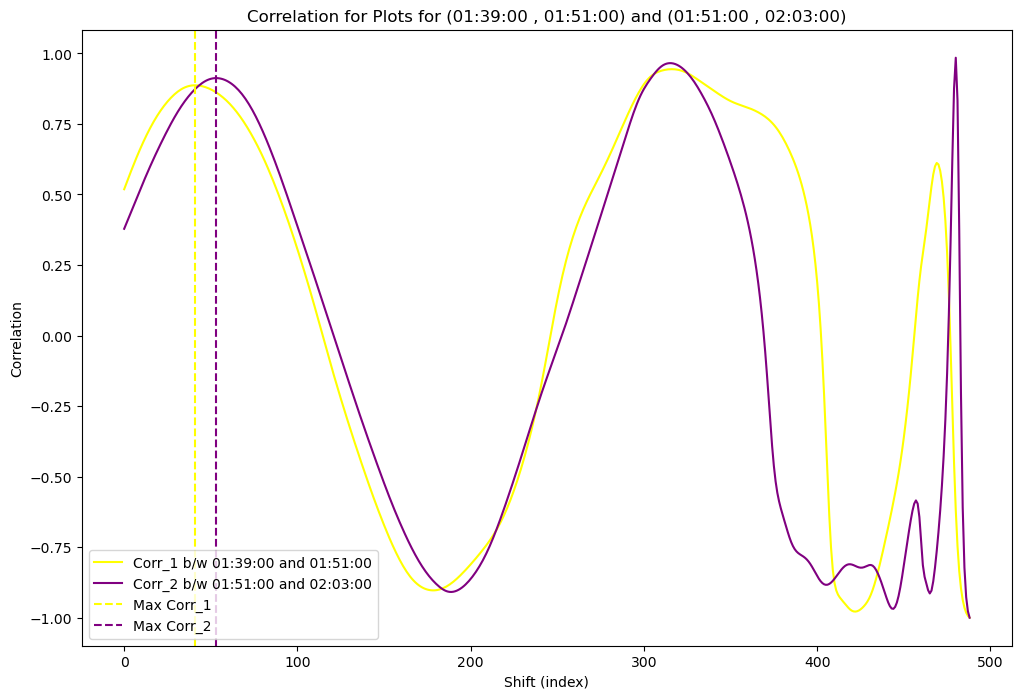

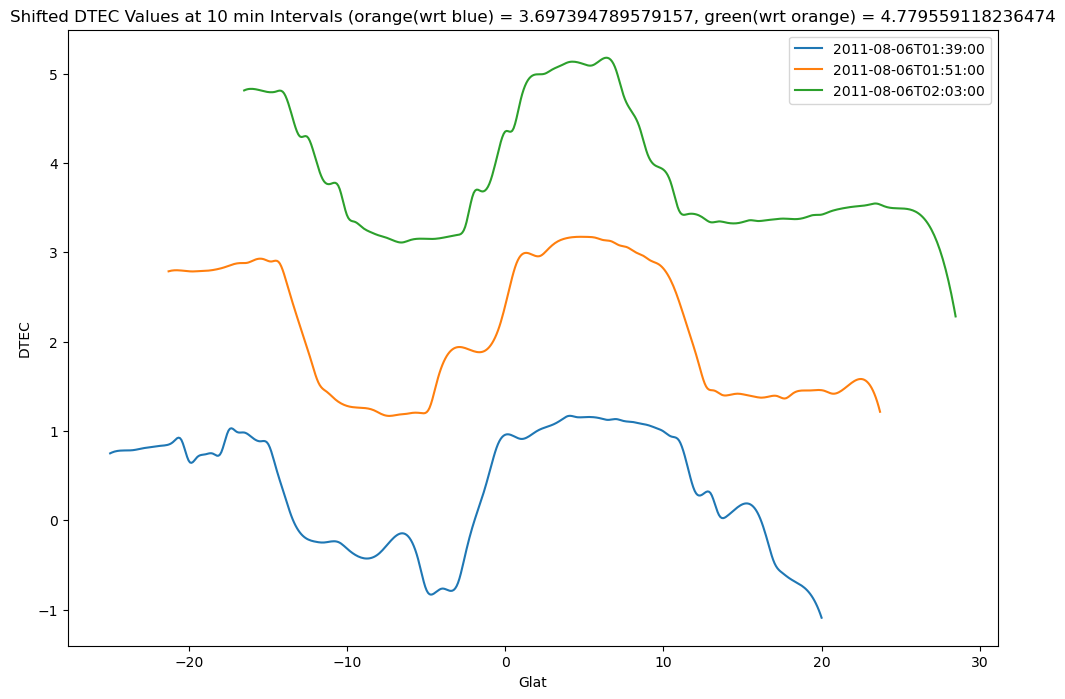

In [65]:
corr1 = correlation(df1.dTEC, df2.dTEC)
corr2 = correlation(df2.dTEC, df3.dTEC)

m1 = max(corr1[:100])
m2 = max(corr2[:100])
s1 = df2.Glat[corr1.index(m1)] - df2.Glat[0]
s2 = df3.Glat[corr2.index(m2)] - df3.Glat[0]
print('Lat diff of peaks ' + str(s2-s1))

print('Shift 1 =', s1, 'glats, Shift 2 =', s2, 'glats')
t1 = int(e-d)/(60*10**9)
slope1 = s1/t1

t2 = int(f-e)/(60*10**9)
slope2 = s2/t2
print('slope 1 =', slope1, '(glat/min), Slope 2 =', slope2, '(glat/min)')

plt.figure(figsize=(12,8))
plt.plot(corr1, label = 'Corr_1 b/w ' + str(d)[11:-10] + ' and ' + str(e)[11:-10], color = 'yellow')
plt.plot(corr2, label = 'Corr_2 b/w ' + str(e)[11:-10] + ' and ' + str(f)[11:-10], color = 'purple')
plt.ylabel('Correlation')
plt.xlabel('Shift (index)')
plt.axvline(x=corr1.index(m1), color='yellow', linestyle='--', label='Max Corr_1')
plt.axvline(x=corr2.index(m2), color='purple', linestyle='--', label='Max Corr_2')
plt.title('Correlation for Plots for (' + str(d)[11:-10] + ' , ' + str(e)[11:-10] + ') and (' + str(e)[11:-10] + ' , ' + str(f)[11:-10] + ')')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(df1.Glat.values, df1.dTEC.values, label = str(d)[:-10])
plt.plot(df2.Glat.values + s1, df2.dTEC.values+2, label = str(e)[:-10])
plt.plot(df3.Glat.values + s2 + s1, df3.dTEC.values+4, label = str(f)[:-10])
plt.title('Shifted DTEC Values at 10 min Intervals (orange(wrt blue) = ' + str(s1) + ', green(wrt orange) = ' + str(s2))
plt.xlabel('Glat')
plt.ylabel('DTEC')
plt.legend()

### Rewritten Code

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
import importlib as il
import datetime as dt
from scipy.interpolate import CubicSpline

from utility_programs import filters
from scipy.signal import find_peaks, savgol_filter
from multiprocessing import Pool, cpu_count

import numpy as np

np.seterr(divide='ignore', invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
path = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Cesar_data/'


date = ['20130316', '20130317', '20130318']
data = []

for d in date:
    p = path + 'file' + d + '.dTEC'
    df = df = pd.read_csv(p, delim_whitespace=True, skiprows=1)
    lat1 = []
    lat2 = []
    lon1 = []
    lon2 = []
    dtec = []
    ds = xr.Dataset.from_dataframe(df)
    print(ds)
    data.append(ds)

<xarray.Dataset>
Dimensions:  (index: 86131)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 86125 86126 86127 86128 86129 86130
Data variables:
    lat1     (index) float64 -80.0 -80.0 -80.0 -80.0 ... 62.0 62.0 62.0 62.0
    lat2     (index) float64 -79.5 -79.5 -79.5 -79.5 ... 62.5 62.5 62.5 62.5
    lon1     (index) int64 0 180 360 540 720 ... 75420 75600 75780 75960 76140
    lon2     (index) int64 360 540 720 900 1080 ... 75960 76140 76320 76500
    dtec     (index) int64 23 28 80 28 25 25 11 7 4 ... 79 80 30 80 81 82 81 81
<xarray.Dataset>
Dimensions:  (index: 103063)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 ... 103058 103059 103060 103061 103062
Data variables:
    lat1     (index) float64 -80.0 -80.0 -80.0 -80.0 ... 62.0 62.0 62.0 62.0
    lat2     (index) float64 -79.5 -79.5 -79.5 -79.5 ... 62.5 62.5 62.5 62.5
    lon1     (index) int64 0 180 360 540 720 ... 75240 75420 75600 75780 75960
    lon2     (index) int64 360 540 720 900 1080 ... 75780 75960 76140 

In [3]:
dates = ['2011-08-06']

for d in dates:
    p = path + d + '.csv'
    df = pd.read_csv(p)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace = True)
    ds = df.to_xarray()
    print(ds)


<xarray.Dataset>
Dimensions:   (Datetime: 252357)
Coordinates:
  * Datetime  (Datetime) datetime64[ns] 2011-08-05 ... 2011-08-07T23:57:00
Data variables:
    Glat      (Datetime) float64 -44.0 23.5 -29.0 -2.0 ... -25.5 -54.0 -5.5 17.5
    dTEC      (Datetime) float64 -0.3556 -0.3778 -0.4222 ... -0.3778 -0.3333


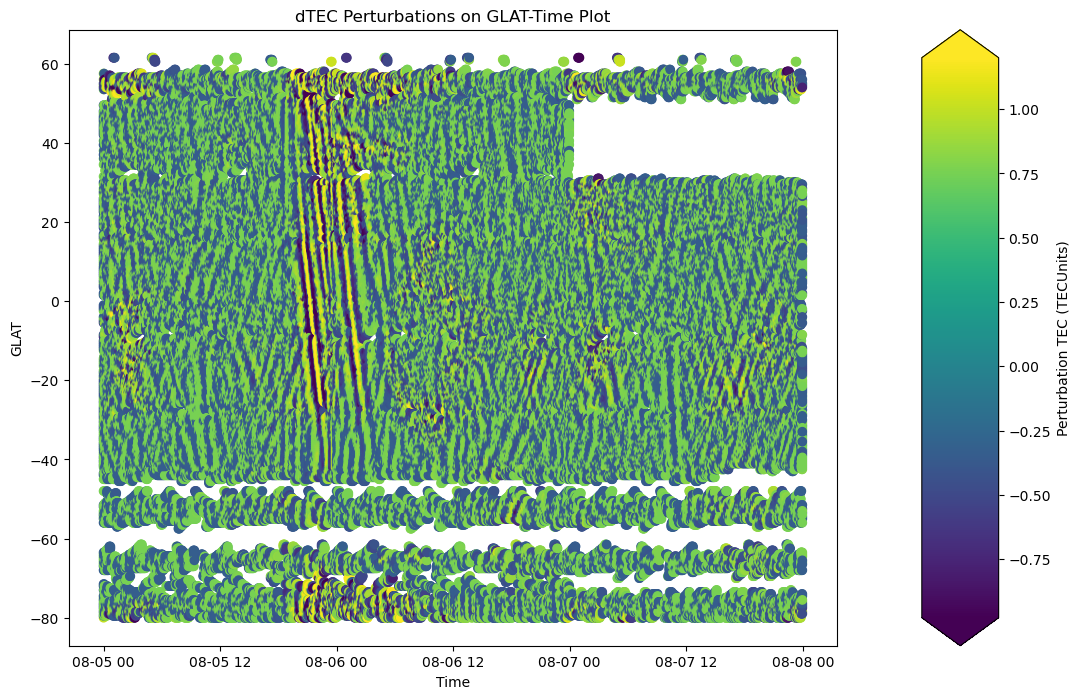

In [4]:
fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
c = ax[0].scatter(ds.Datetime.values, ds.Glat.values, c=ds.dTEC.values)
ax[0].set_title('dTEC Perturbations on GLAT-Time Plot')
ax[0].set_ylabel('GLAT')
ax[0].set_xlabel('Time')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
fig.show()

In [7]:
def ds_trim(ds, a, b, l1, l2):
    ds_n = ds.isel(Datetime=slice(a,b))
    ds_n = ds_n.where((ds_n.Glat > l1), drop=True)
    ds_n = ds_n.where((ds_n.Glat < l2), drop=True)
    
    return ds_n

In [15]:
def smoothen(func, lats):
    y = savgol_filter(func.dTEC.values, 5, 1)
    cs = CubicSpline(func.Glat.values, y)
    y1 = cs(lats)
    df = pd.DataFrame()
    df['Glat'] = lats
    df['dTEC'] = y1

    return df

In [18]:
def correlation(df1, df2):
    corr1 = []
    for i in range(len(df2)-10):
        l1 = len(df2)-10
        n = 0
        d1 = 0
        d2 = 0
        u1 = np.sum(df1[i:l1])/(l1-i)
        u2 = np.sum(df2[:l1-i])/(l1-i)
        
        for j,k in zip(df1[i:l1], df2[:l1-i]):
            n += (j-u1)*(k-u2)
            d1 += (j-u1)**2
            d2 += (k-u2)**2
        c = n/(np.sqrt(d1*d2))
        corr1.append(c)
    
    return corr1

In [41]:
def main(ds_n, l1, l2, plot_3 = False, time1 = 0, time2 = 0, time3 = 0):

    speed = []
    lat_shift = []
    time = []
    
    i = 0
    j = 250
    
    while j < len(ds_n.dTEC.values):

        d = ds_n.Datetime.values[i]
        e = ds_n.Datetime.values[j]
        
        df = ds_n.to_pandas()
        df_1 = (df.iloc[np.where((ds_n.Datetime == d))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
        df_2 = (df.iloc[np.where((ds_n.Datetime == e))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
        
        lats = np.linspace(l1,l2, 500)
        df1 = smoothen(df_1, lats)
        df2 = smoothen(df_2, lats)
        
        corr1 = correlation(df1.dTEC, df2.dTEC)
        m1 = max(corr1[:100])
        s1 = df2.Glat[corr1.index(m1)] - df2.Glat[0]
        t1 = int(e-d)/(60*10**9)
        slope1 = s1/t1
        
        speed.append(slope1)
        lat_shift.append(s1)
        time.append(ds_n.Datetime.values[int((i+j)/2)])
        i += 250
        j += 250

    # Plotting on Keogram
    fig1 = plt.figure(figsize=(12,8))
    specs1 = fig1.add_gridspec(1, 2, width_ratios=[1,0.1])
    ax1 = []
    ax1.append(fig1.add_subplot(specs1[0, 0]))
    c1 = ax1[0].scatter(ds_n.Datetime.values, ds_n.Glat.values, c=ds_n.dTEC.values)
    ax1[0].set_title('dTEC Perturbations on GLAT-Time Plot')
    ax1[0].set_xlabel('Time')
    ax1[0].set_ylabel('GLAT')   
    ax2 = ax1[0].twinx()
    ax2.plot(time, speed, color = 'r', linestyle = '--')
    ax2.set_ylim(-0.1,1.1)
    ax2.set_ylabel('Speed (glat/min)', color = 'red')
    
    
    if(plot_3):
        
        # Plotting 3 required lines
        ax1[0].axvline(x=ds_n.Datetime.values[time1], color='blue')
        ax1[0].axvline(x=ds_n.Datetime.values[time2], color='orange')
        ax1[0].axvline(x=ds_n.Datetime.values[time3], color='green')
        
        
        d = ds_n.Datetime.values[time1]
        e = ds_n.Datetime.values[time2]
        f = ds_n.Datetime.values[time3]
        
        df = ds_n.to_pandas()
        df_1 = (df.iloc[np.where((ds_n.Datetime == d))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
        df_2 = (df.iloc[np.where((ds_n.Datetime == e))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
        df_3 = (df.iloc[np.where((ds_n.Datetime == f))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
        
        df1 = smoothen(df_1, lats)
        df2 = smoothen(df_2, lats)
        df3 = smoothen(df_3, lats)
        
        plt.figure(figsize=(12,8))
        plt.plot(df1.Glat.values, df1.dTEC.values, label = str(d)[:-10])
        plt.plot(df2.Glat.values, df2.dTEC.values+2, label = str(e)[:-10])
        plt.plot(df3.Glat.values, df3.dTEC.values+4, label = str(f)[:-10])
        plt.title('Smooth (Savgol Ord=2) DTEC Values at Intervals of 10 Min')
        plt.xlabel('Glat')
        plt.ylabel('DTEC')
        plt.legend()


        corr1 = correlation(df1.dTEC, df2.dTEC)
        corr2 = correlation(df2.dTEC, df3.dTEC)
        
        m1 = max(corr1[:100])
        m2 = max(corr2[:100])
        s1 = df2.Glat[corr1.index(m1)] - df2.Glat[0]
        s2 = df3.Glat[corr2.index(m2)] - df3.Glat[0]
        print('Lat diff of peaks ' + str(s2-s1))
        
        print('Shift 1 =', s1, 'glats, Shift 2 =', s2, 'glats')
        t1 = int(e-d)/(60*10**9)
        slope1 = s1/t1
        
        t2 = int(f-e)/(60*10**9)
        slope2 = s2/t2
        print('slope 1 =', slope1, '(glat/min), Slope 2 =', slope2, '(glat/min)')
        
        plt.figure(figsize=(12,8))
        plt.plot(corr1, label = 'Corr_1 b/w ' + str(d)[11:-10] + ' and ' + str(e)[11:-10], color = 'yellow')
        plt.plot(corr2, label = 'Corr_2 b/w ' + str(e)[11:-10] + ' and ' + str(f)[11:-10], color = 'purple')
        plt.ylabel('Correlation')
        plt.xlabel('Shift (index)')
        plt.axvline(x=corr1.index(m1), color='yellow', linestyle='--', label='Max Corr_1')
        plt.axvline(x=corr2.index(m2), color='purple', linestyle='--', label='Max Corr_2')
        plt.title('Correlation for Plots for (' + str(d)[11:-10] + ' , ' + str(e)[11:-10] + ') and (' + str(e)[11:-10] + ' , ' + str(f)[11:-10] + ')')
        plt.legend()
        
        plt.figure(figsize=(12,8))
        plt.plot(df1.Glat.values, df1.dTEC.values, label = str(d)[:-10])
        plt.plot(df2.Glat.values + s1, df2.dTEC.values+2, label = str(e)[:-10])
        plt.plot(df3.Glat.values + s2 + s1, df3.dTEC.values+4, label = str(f)[:-10])
        plt.title('Shifted DTEC Values at 10 min Intervals (orange(wrt blue) = ' + str(s1) + ', green(wrt orange) = ' + str(s2))
        plt.xlabel('Glat')
        plt.ylabel('DTEC')
        plt.legend()

    
    cbar_ax1 = fig1.add_subplot(specs1[0,1])
    cbar1 = fig.colorbar(c1, cax=cbar_ax1, label='Perturbation TEC (TECUnits)', extend='both')
    fig.show()

    return ds_n, speed, lat_shift

Lat diff of peaks 0.8116232464929851
Shift 1 = 3.6072144288577164 glats, Shift 2 = 4.4188376753507015 glats
slope 1 = 0.40080160320641295 (glat/min), Slope 2 = 0.3682364729458918 (glat/min)


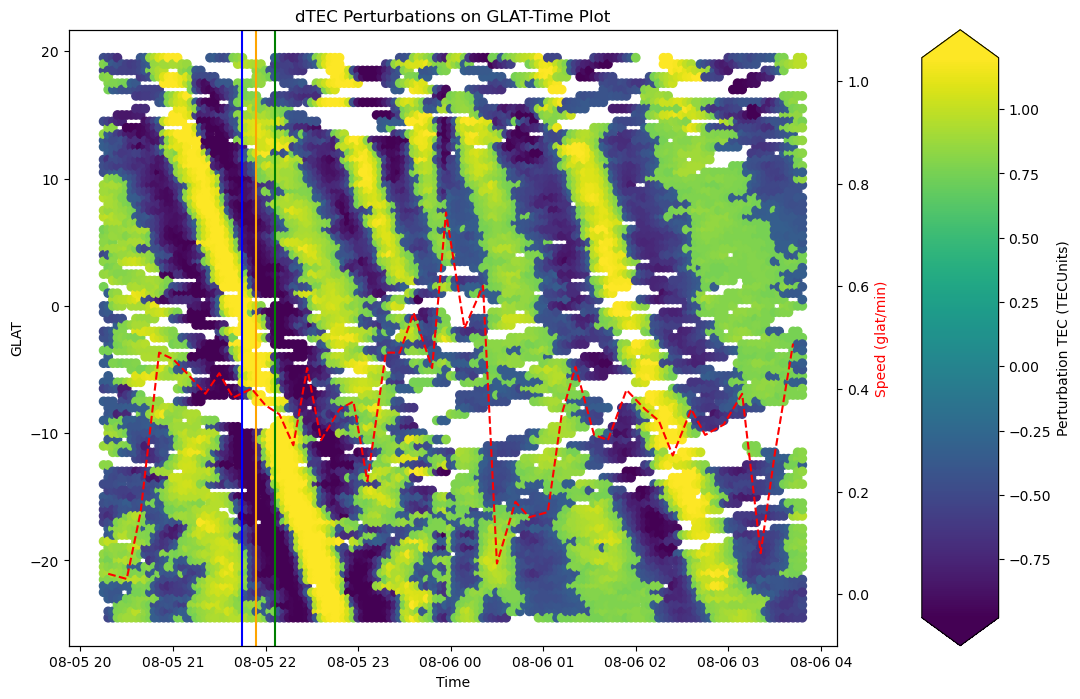

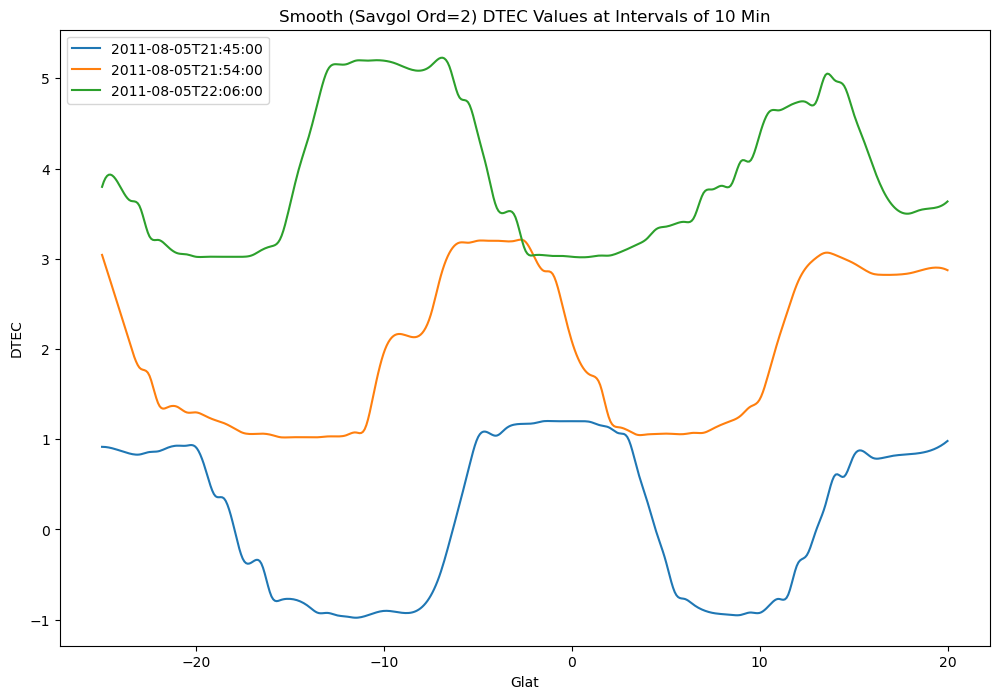

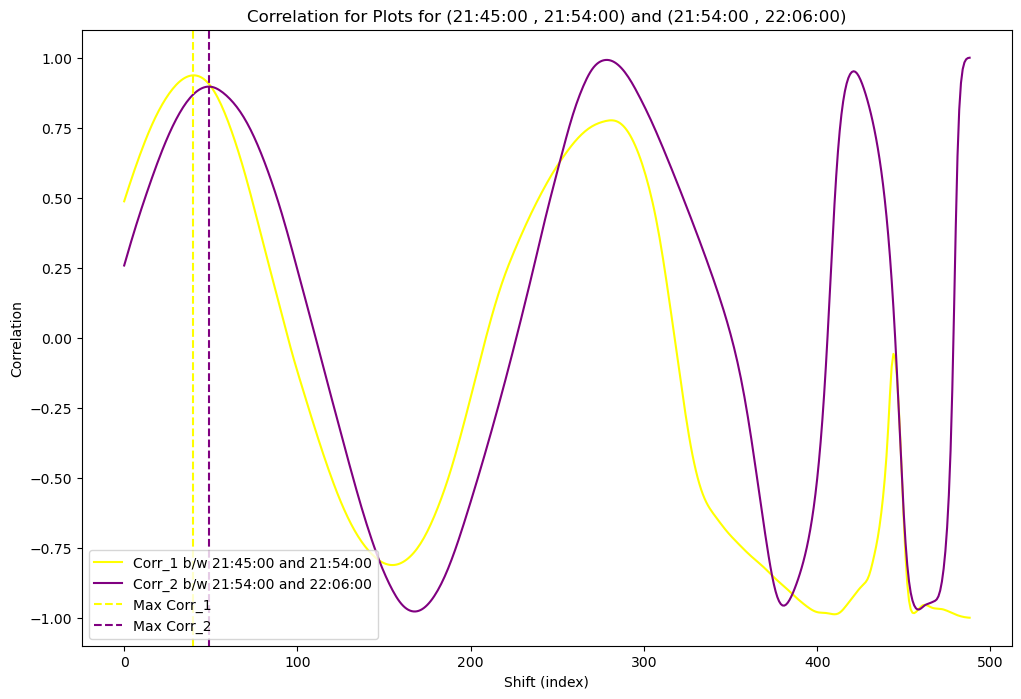

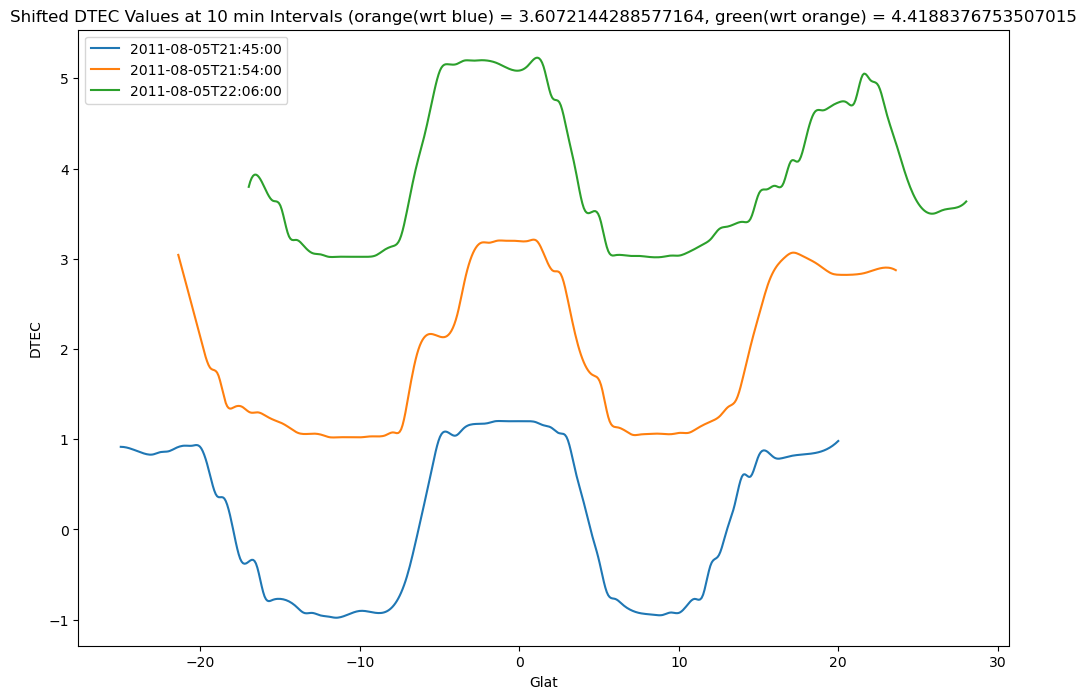

In [42]:
a = 75000
b = 103000
# Limits of latitudes
l1 = -25
l2 = 20

ds_n = ds_trim(ds, a, b, l1, l2) 

i = 0
time = [0]

# index to set the time of observations
time1 = 2250
time2 = 2500
time3 = 2750
plot_3 = True

ds_n, speed, lat_shift = main(ds_n, l1, l2, plot_3, time1, time2, time3)



11036 152
2011-08-06T03:03:00.000000000 2011-08-06T03:15:00.000000000 2011-08-06T03:24:00.000000000


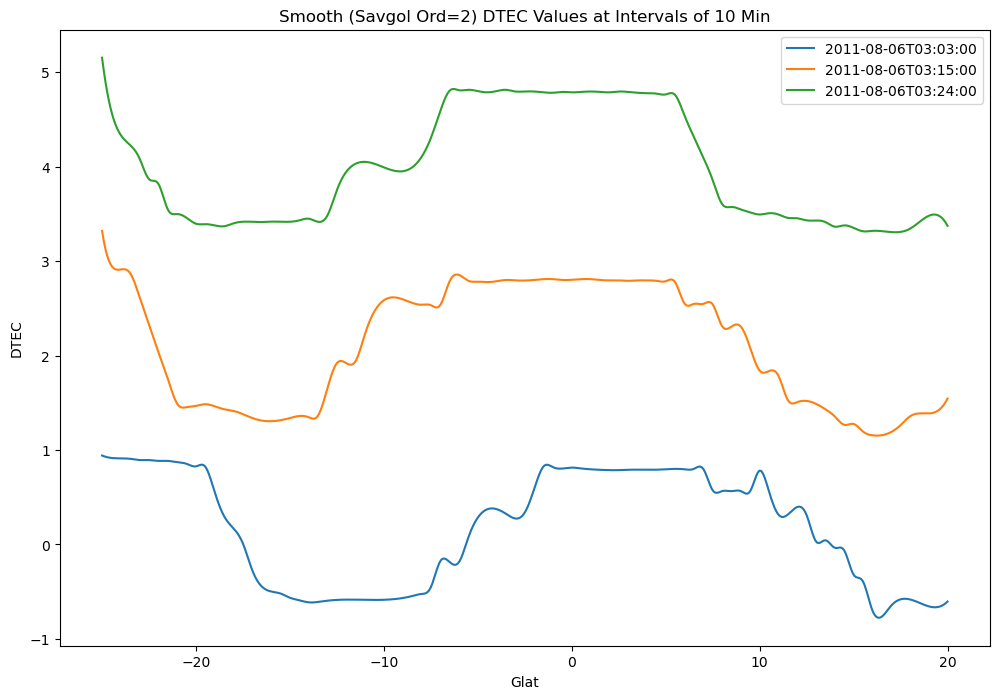

In [15]:
print(len(ds_n.Glat.values), len(np.unique(ds_n.Datetime.values)))

d = ds_n.Datetime.values[time1]
e = ds_n.Datetime.values[time2]
f = ds_n.Datetime.values[time3]
print(d,e,f)

df = ds_n.to_pandas()
df_1 = (df.iloc[np.where((ds_n.Datetime == d))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
df_2 = (df.iloc[np.where((ds_n.Datetime == e))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
df_3 = (df.iloc[np.where((ds_n.Datetime == f))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)

#print(len(df1.dTEC.values), len(df2.dTEC.values), len(df3.dTEC.values)) 
lats = np.linspace(l1,l2, 500)
df1 = smoothen(df_1, lats)
df2 = smoothen(df_2, lats)
df3 = smoothen(df_3, lats)

plt.figure(figsize=(12,8))
plt.plot(df1.Glat.values, df1.dTEC.values, label = str(d)[:-10])
plt.plot(df2.Glat.values, df2.dTEC.values+2, label = str(e)[:-10])
plt.plot(df3.Glat.values, df3.dTEC.values+4, label = str(f)[:-10])
plt.title('Smooth (Savgol Ord=2) DTEC Values at Intervals of 10 Min')
plt.xlabel('Glat')
plt.ylabel('DTEC')
plt.legend()

In [16]:
def correlation(df1, df2):
    corr1 = []
    for i in range(len(df2)-10):
        l1 = len(df2)-10
        n = 0
        d1 = 0
        d2 = 0
        u1 = np.sum(df1[i:l1])/(l1-i)
        u2 = np.sum(df2[:l1-i])/(l1-i)
        
        for j,k in zip(df1[i:l1], df2[:l1-i]):
            n += (j-u1)*(k-u2)
            d1 += (j-u1)**2
            d2 += (k-u2)**2
        c = n/(np.sqrt(d1*d2))
        corr1.append(c)
    
    return corr1

/tmp/ipykernel_124296/3761207125.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c = n/(np.sqrt(d1*d2))


Lat diff of peaks -3.967935871743485
Shift 1 = 4.68937875751503 glats, Shift 2 = 0.7214428857715447 glats
slope 1 = 0.3907815631262525 (glat/min), Slope 2 = 0.08016032064128274 (glat/min)


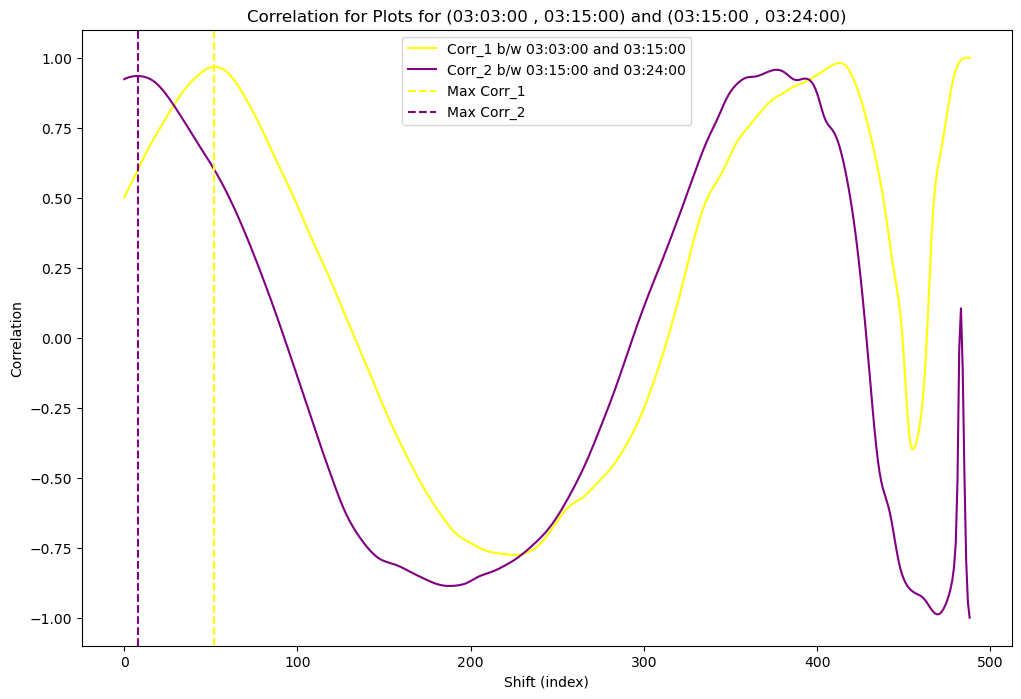

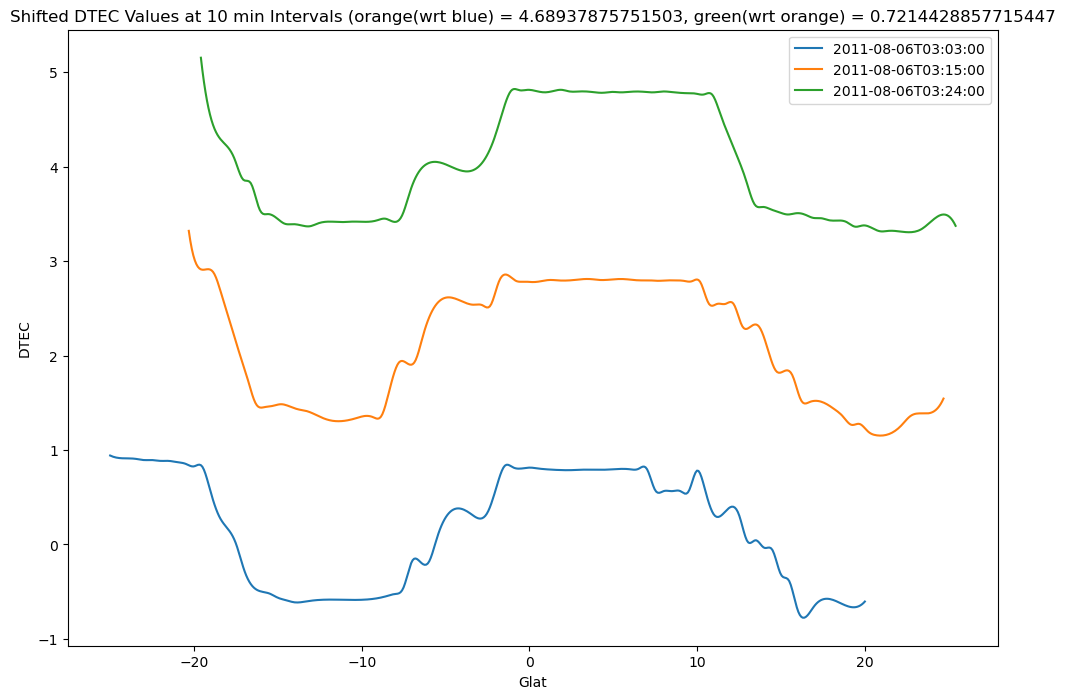

In [17]:
corr1 = correlation(df1.dTEC, df2.dTEC)
corr2 = correlation(df2.dTEC, df3.dTEC)

m1 = max(corr1[:100])
m2 = max(corr2[:100])
s1 = df2.Glat[corr1.index(m1)] - df2.Glat[0]
s2 = df3.Glat[corr2.index(m2)] - df3.Glat[0]
print('Lat diff of peaks ' + str(s2-s1))

print('Shift 1 =', s1, 'glats, Shift 2 =', s2, 'glats')
t1 = int(e-d)/(60*10**9)
slope1 = s1/t1

t2 = int(f-e)/(60*10**9)
slope2 = s2/t2
print('slope 1 =', slope1, '(glat/min), Slope 2 =', slope2, '(glat/min)')

plt.figure(figsize=(12,8))
plt.plot(corr1, label = 'Corr_1 b/w ' + str(d)[11:-10] + ' and ' + str(e)[11:-10], color = 'yellow')
plt.plot(corr2, label = 'Corr_2 b/w ' + str(e)[11:-10] + ' and ' + str(f)[11:-10], color = 'purple')
plt.ylabel('Correlation')
plt.xlabel('Shift (index)')
plt.axvline(x=corr1.index(m1), color='yellow', linestyle='--', label='Max Corr_1')
plt.axvline(x=corr2.index(m2), color='purple', linestyle='--', label='Max Corr_2')
plt.title('Correlation for Plots for (' + str(d)[11:-10] + ' , ' + str(e)[11:-10] + ') and (' + str(e)[11:-10] + ' , ' + str(f)[11:-10] + ')')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(df1.Glat.values, df1.dTEC.values, label = str(d)[:-10])
plt.plot(df2.Glat.values + s1, df2.dTEC.values+2, label = str(e)[:-10])
plt.plot(df3.Glat.values + s2 + s1, df3.dTEC.values+4, label = str(f)[:-10])
plt.title('Shifted DTEC Values at 10 min Intervals (orange(wrt blue) = ' + str(s1) + ', green(wrt orange) = ' + str(s2))
plt.xlabel('Glat')
plt.ylabel('DTEC')
plt.legend()